# 导入第三方库

In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from random import *
from math import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from collections import Counter
from itertools import cycle
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# import tensorflow as tf
import matplotlib as mpl
import seaborn as sns

# 数据输入和准备

In [2]:
otu_label = pd.read_csv("otutab_all.csv",header=0,index_col=0)
otu = otu_label.drop("label",axis=1)
label = otu_label["label"]
label[label=="XR"] = "PL"
label[label=="JK"] = "NM"
label[label=="JZ"] = "AA"
label[label=="FJ"] = "NAA"

<ipython-input-2-b53c83cb9c76>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label[label=="XR"] = "PL"
<ipython-input-2-b53c83cb9c76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label[label=="JK"] = "NM"
<ipython-input-2-b53c83cb9c76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label[label=="JZ"] = "AA"
<ipython-input-2-b53c83cb9c76>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [3]:
##-------------------定义特征筛选函数----------------
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def filter(otu_f,thread):
    n = len(otu_f)
    columns = otu_f.columns
    indexs = otu_f.index
    # 删除表达低的特征并对样本进行归一化
    for col in columns:
        more_thread = round(len(otu_f.loc[otu_f[col]>thread,col])/n,2)*100
        if more_thread < 10:
            otu_f.drop(col,axis=1,inplace=True)
    mm = MinMaxScaler()
    mm_data = mm.fit_transform(np.transpose(otu_f))
    otu_result = pd.DataFrame(np.transpose(mm_data))
    otu_result.columns = otu_f.columns     
    return otu_result
otu_filter = otu
otu_filter = filter(otu_filter,10)

In [4]:
otu_filter.index = otu.index
otu_filter = np.transpose(otu_filter)

In [5]:
numeric_cols = otu_filter.columns[otu_filter.dtypes != "object"]
numeric_col_sum =otu_filter.loc[:,numeric_cols].sum()
otu_filter.loc[:,numeric_cols] = otu_filter.loc[:,numeric_cols]/numeric_col_sum*100
otu_label=pd.concat([label, np.transpose(otu_filter)], axis=1)

In [6]:
otu = otu_label.drop("label",axis=1)
label = otu_label["label"]

Text(0, 0.5, 'raw_sample_var')

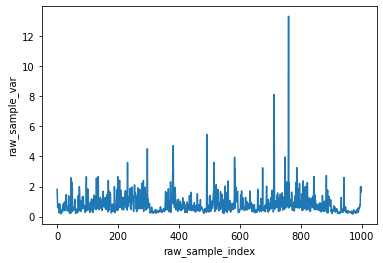

In [7]:
arr_var = np.var(otu,axis=1)
plt.plot(range(0,999),arr_var) 
plt.xlabel("raw_sample_index")
plt.ylabel("raw_sample_var")
# plt.savefig("raw_sample_var.svg", format="svg") #保存矢量图

Text(0, 0.5, 'filter_sample_var')

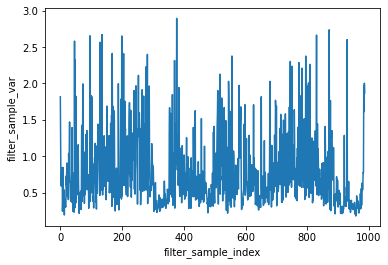

In [8]:
arr_var[arr_var<=4]
otu_filter1 = otu[np.var(otu,axis=1)<=3]
arr_var = np.var(otu_filter1,axis=1)
plt.plot(range(0,len(arr_var)),arr_var) 
plt.xlabel("filter_sample_index")
plt.ylabel("filter_sample_var")
# plt.savefig("filter_sample_var.svg", format="svg") #保存矢量图

In [9]:
index = otu_filter1.index
label = label[index]

In [10]:
otu_label=pd.concat([label, otu_filter1], axis=1)
Counter(otu_label["label"])

Counter({'CR': 200, 'NAA': 197, 'NM': 195, 'AA': 195, 'PL': 200})

In [11]:
Counter(label)

Counter({'CR': 200, 'NAA': 197, 'NM': 195, 'AA': 195, 'PL': 200})

In [28]:
otu_label

,label,Otu133,Otu2,Otu159,Otu138,Otu37,Otu13,Otu26,Otu60,Otu4,...,Otu317,Otu428,Otu439,Otu289,Otu336,Otu421,Otu481,Otu344,Otu469,Otu151
CR001,CR,28.836548,5.255339,11.098433,0.493024,0.512401,1.952721,3.044265,0.234671,0.671719,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.00000
CR002,CR,0.125912,11.829357,0.179265,0.049084,0.674378,0.554868,2.151180,0.264629,5.740749,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.00000
CR003,CR,0.688369,4.867433,0.448550,0.066616,0.759426,2.447040,0.719456,0.346405,3.250877,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.00000
CR004,CR,1.116356,3.435229,0.232262,0.198546,0.299693,0.816663,0.584401,0.382108,2.581104,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.00000
CR005,CR,0.808314,5.688834,0.820097,0.103690,0.245086,0.332281,0.645709,4.357355,3.117783,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XRK01,PL,0.000000,3.941439,0.002198,0.065947,0.131894,0.162670,0.833132,0.028577,2.793959,...,0.0,0.0,0.000000,0.052758,0.061551,0.0,0.00000,0.0,0.0,0.00000
XRK02,PL,0.000000,0.545700,0.000000,0.002140,0.027820,0.064200,0.012840,0.000000,4.048878,...,0.0,0.0,0.000000,8.844615,9.863254,0.0,0.00856,0.0,0.0,0.00214
XRK03,PL,0.000000,19.314012,0.146350,0.030919,0.282393,0.505009,0.020613,0.049470,0.152533,...,0.0,0.0,0.002061,0.037103,0.113369,0.0,0.01649,0.0,0.0,0.00000
XRK04,PL,0.000000,1.927849,0.002051,0.010255,0.088189,1.136200,0.088189,0.090240,0.324043,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.00000


# 训练集和测试集划分

In [148]:
##---------训练集和测试集划分---------未考虑测序批次
#train
X=otu_label.drop(['label'], axis=1)# Features
y=otu_label['label']
# otu_label.to_csv("otutab_norm.csv",index=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2050,shuffle=True)
X_train

,Otu133,Otu2,Otu159,Otu138,Otu37,Otu13,Otu26,Otu60,Otu4,Otu112,...,Otu317,Otu428,Otu439,Otu289,Otu336,Otu421,Otu481,Otu344,Otu469,Otu151
CRC06,0.000000,2.369223,0.000000,0.872542,1.045798,15.060744,17.891287,1.924602,0.715985,0.020874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002087,0.000000,0.037574
CR089,0.166032,9.261585,0.000000,0.048958,2.145640,0.334192,1.562400,0.072373,1.858277,0.106431,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.053215,0.000000,0.000000,0.000000,0.000000
XR030,0.000000,5.285794,0.004155,0.004155,0.193231,0.941220,0.623325,0.043633,5.877953,0.006233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004155,0.000000,0.008311
JZB05,0.000000,4.892790,0.000000,0.024670,0.550953,0.861378,0.051395,0.141850,5.186769,0.012335,...,0.000000,0.008223,0.000000,0.000000,0.000000,0.000000,0.094567,0.678412,0.000000,0.000000
CR055,0.000000,12.812989,0.002142,0.023561,0.865337,2.497483,0.848202,0.263457,1.477927,0.057832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JZ048,1.123888,5.356910,0.210458,0.006509,0.277718,7.012367,0.859189,0.229985,6.007811,0.036884,...,0.000000,0.000000,0.114992,0.000000,0.028206,0.000000,0.000000,0.101974,0.041224,0.000000
XRG05,0.008482,4.334365,0.000000,0.086942,0.243861,1.234149,0.163281,0.233258,2.550999,0.012723,...,0.002121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008482,0.000000
FJ037,0.000000,3.155032,0.004151,0.026984,0.244930,0.014530,0.043589,0.514768,2.279096,0.051892,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002076,0.000000
XRA04,0.049357,3.167450,0.002146,0.002146,0.081547,0.336917,0.150218,0.021460,4.317689,0.004292,...,0.023606,0.000000,0.000000,0.100861,0.109444,0.000000,0.000000,0.109444,0.000000,0.289706


## 模型构建及参数调优 

模型一：随机森林

In [31]:
param = {
    'n_estimators':range(10,50,10),
    'max_features':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(random_state=2050),
                        param_grid = param,
                        cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2050),
             n_jobs=-1,
             param_grid={'max_features': range(1, 10),
                         'n_estimators': range(10, 50, 10)})

In [32]:
best_estimator = gsearch1.best_estimator_
#best_estimator = RandomForestClassifier(max_features=8, n_estimators=750, random_state=2050)
print(f'best params:{gsearch1.best_params_}')
print('best accuracy:%f' % gsearch1.best_score_)
print(best_estimator)

best params:{'max_features': 7, 'n_estimators': 40}
best accuracy:0.844928
RandomForestClassifier(max_features=7, n_estimators=40, random_state=2050)


In [33]:
#对训练集进行交叉验证
scores = cross_val_score(best_estimator, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.84 (+/- 0.04)


In [34]:
scores

array([0.84782609, 0.84057971, 0.85507246, 0.86956522, 0.8115942 ])

In [35]:
#对测试集进行测试
best_estimator.fit(X_train,y_train)
#y_pred=best_estimator.predict_proba(X_test)
y_pred=best_estimator.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8451178451178452


In [36]:
y_train.value_counts()

NAA    149
PL     146
CR     141
NM     136
AA     118
Name: label, dtype: int64

In [37]:
y_test.value_counts()

AA     77
CR     59
NM     59
PL     54
NAA    48
Name: label, dtype: int64

In [38]:
y_test_pred=best_estimator.predict_proba(X_test)

In [23]:
# nn = pd.DataFrame(pd.concat([pd.DataFrame(y_test_pred,columns=['CR','FJ','JK','JZ','XR']),
#                              pd.DataFrame(y_test.values,columns=['True_label']),
#                             pd.DataFrame(y_test._stat_axis.values.tolist(),columns=['Sample']),
#                             pd.DataFrame(y_pred,columns=['Pred_label'])
#                             ],axis=1))
# nn.head()
# nn.to_csv('y_test_pred.csv',index=0)

In [39]:
alldata = pd.DataFrame(pd.concat([pd.DataFrame(y_test._stat_axis.values.tolist(),columns=['Sample']),
                             pd.DataFrame(y_test.values,columns=['True_label']),
                             pd.DataFrame(y_pred,columns=['Pred_label']),
                             pd.DataFrame(np.array(X_test),columns=X_test.columns)
                            ],axis=1))

In [25]:
# alldata.to_csv('alldata.csv',index=0)

In [26]:
# predict_probs = best_estimator.predict_proba(X)
# all_probs = pd.concat([pd.DataFrame(X.index),pd.DataFrame(predict_probs,columns=['JK','JZ','CR'])],axis=1)
# all_probs[:10].to_csv('all_probs_text.csv',index=0)

In [40]:
importance = best_estimator.feature_importances_
feature_imp = pd.Series(importance,index=X_train.columns).sort_values(ascending=False)
feature_imp

Otu325    0.013061
Otu511    0.012874
Otu153    0.009037
Otu367    0.007230
Otu186    0.006274
            ...   
Otu578    0.000266
Otu4      0.000203
Otu421    0.000136
Otu398    0.000134
Otu250    0.000067
Length: 561, dtype: float64

In [41]:
filter_feature = feature_imp[feature_imp.values>0.002] 
filter_feature.index
filter_feature.head()
# filter_feature = feature_imp
# filter_feature.to_csv('filter_feature.csv',index=1)
filter_feature.head()

Otu325    0.013061
Otu511    0.012874
Otu153    0.009037
Otu367    0.007230
Otu186    0.006274
dtype: float64

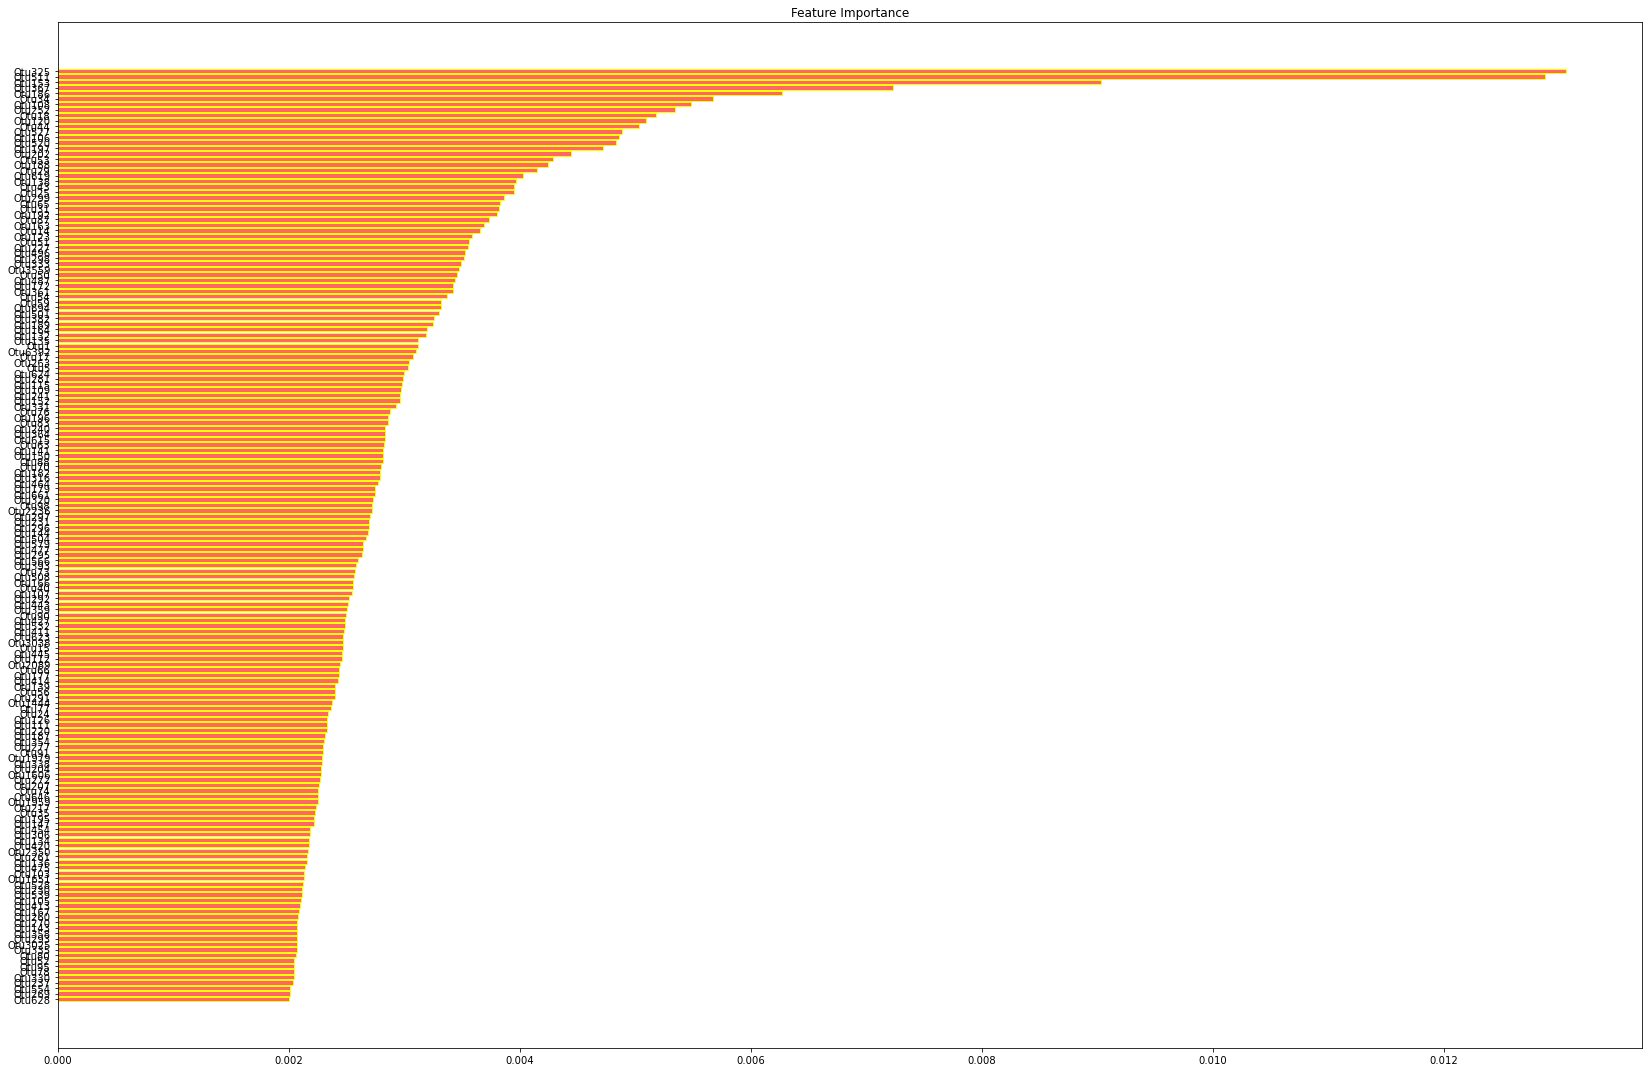

In [42]:
# plot feature importance
indices = np.argsort(filter_feature)
selectn = filter_feature.shape[0]
fig=plt.figure(figsize=(23,15))
ax=fig.add_subplot(111)

ax.barh(range(selectn),filter_feature[indices],facecolor='#FF6666', edgecolor='#FFFF00')
ax.set_yticks(range(selectn))
ax.set_yticklabels(indices[::-1].index)
#ax.set_xlim(0, np.max(indices,)*1.1)
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

模型二: 逻辑回归、决策树、KNN、朴素贝叶斯、支持向量机

In [158]:
from sklearn.model_selection import cross_val_score   # 10折交叉验证评价模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline   # 管道简化工作流
from sklearn.preprocessing import StandardScaler  # 标准化数据
from sklearn.preprocessing import LabelEncoder   # 标签化分类变量
from sklearn.naive_bayes import GaussianNB
import sklearn.svm as svm

clf1 = LogisticRegression(penalty='l2',C=0.001)
clf2 = DecisionTreeClassifier()
clf3 = KNeighborsClassifier()
clf4 = GaussianNB()
clf5 = svm.SVC(kernel='poly', degree=3)


clf_labels = ['Logistic regression','Decision tree','KNN',"Naive Bayes","svm"]
print('5-folds cross validation :\n')
for clf,label in zip([clf1,clf2,clf3,clf4,clf5],clf_labels):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(scores)
    print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

5-folds cross validation :

[0.47826087 0.47826087 0.43478261 0.46376812 0.50724638]
ACCURACY: 0.47(+/- 0.02)[Logistic regression]
Accuracy: 0.4208754208754209
[0.63768116 0.58695652 0.63043478 0.61594203 0.62318841]
ACCURACY: 0.62(+/- 0.02)[Decision tree]
Accuracy: 0.6127946127946128
[0.4057971  0.4057971  0.35507246 0.39130435 0.36956522]
ACCURACY: 0.39(+/- 0.02)[KNN]
Accuracy: 0.3400673400673401
[0.55072464 0.52173913 0.47101449 0.54347826 0.58695652]
ACCURACY: 0.53(+/- 0.04)[Naive Bayes]
Accuracy: 0.5117845117845118
[0.47101449 0.39855072 0.39130435 0.43478261 0.48550725]
ACCURACY: 0.44(+/- 0.04)[svm]
Accuracy: 0.367003367003367


# 集成模型

MajorityVoteClassifier集成

In [121]:
## 我们使用MajorityVoteClassifier集成：
from sklearn.ensemble import VotingClassifier
mv_clf = VotingClassifier(estimators=[('clf1',clf1),('clf2',clf2),('clf3',clf3)],voting='soft')
clf_labels = ['Logistic regression','Decision tree','KNN','MajorityVoteClassifier']
all_clf = [clf1,clf2,clf3,mv_clf]
print('5-folds cross validation :\n')
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5)
    print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
## 对比下面结果，可以得知多数投票方式的分类算法，抗差能力更强。

5-folds cross validation :

ACCURACY: 0.47(+/- 0.02)[Logistic regression]
Accuracy: 0.4208754208754209
ACCURACY: 0.61(+/- 0.02)[Decision tree]
Accuracy: 0.6127946127946128
ACCURACY: 0.39(+/- 0.04)[KNN]
Accuracy: 0.367003367003367
ACCURACY: 0.62(+/- 0.02)[MajorityVoteClassifier]
Accuracy: 0.6060606060606061


bagging思想的套袋集成技术

In [124]:
# 基于bagging思想的套袋集成技术
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=None)   #选择决策树为基本分类器
bag = BaggingClassifier(base_estimator=tree,n_estimators=10,max_samples=.5,max_features=1.0,bootstrap=True,
                        bootstrap_features=False,n_jobs=1,random_state=1)
from sklearn.metrics import accuracy_score
bag = bag.fit(X_train,y_train)
# y_train_pred = bag.predict(X_train)
# y_test_pred = bag.predict(X_test)
# bag_train = accuracy_score(y_train,y_train_pred)
# bag_test = accuracy_score(y_test,y_test_pred)
# print('Bagging train/test accuracies %.3f/%.3f' % (bag_train,bag_test))
scores = cross_val_score(estimator=bag,X=X_train,y=y_train,cv=5)
print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),"bag"))
bag.fit(X_train,y_train)
y_pred=bag.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ACCURACY: 0.67(+/- 0.03)[bag]
Accuracy: 0.7542087542087542


Adaboost集成建模

In [126]:
# 基于boosting思想的自适应增强方法----Adaboost集成建模
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=2,learning_rate=0.01,random_state=1)
# ada = ada.fit(X_train,y_train)
# y_train_pred = ada.predict(X_train)
# y_test_pred = ada.predict(X_test)
# ada_train = accuracy_score(y_train,y_train_pred)
# ada_test = accuracy_score(y_test,y_test_pred)
# print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))
clf = ada
scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5)
print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),"ada"))
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ACCURACY: 0.63(+/- 0.06)[ada]
Accuracy: 0.6464646464646465


StackingCVRegressor

In [151]:
y_train[y_train=="NM"] = "1"
y_train[y_train=="PL"] = "2"
y_train[y_train=="NAA"] = "3"
y_train[y_train=="AA"] = "4"
y_train[y_train=="CR"] = "5"

In [152]:
y_test[y_test=="NM"] = "1"
y_test[y_test=="PL"] = "2"
y_test[y_test=="NAA"] = "3"
y_test[y_test=="AA"] = "4"
y_test[y_test=="CR"] = "5"

In [131]:
## 1. 简单堆叠5折CV分类
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 2050

clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier(max_features=7, n_estimators=40, random_state=2050)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

5-fold cross validation:

Accuracy: 0.39 (+/- 0.02) [KNN]
Accuracy: 0.3400673400673401
Accuracy: 0.84 (+/- 0.02) [Random Forest]
Accuracy: 0.8249158249158249
Accuracy: 0.53 (+/- 0.04) [Naive Bayes]
Accuracy: 0.5117845117845118


E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Accuracy: 0.76 (+/- 0.01) [StackingClassifier]
Accuracy: 0.7474747474747475


E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Xgboost训练模型

In [183]:
## Xgboost训练模型
from xgboost import XGBClassifier
clf = XGBClassifier(learning_rate =0.1,
 n_estimators=10,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#对测试集测试
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.82608696 0.84057971 0.82608696 0.88405797 0.80434783]
Accuracy: 0.84 (+/- 0.05)
[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are onl

E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.8181818181818182
